> Описание задания

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 
Описание колонок

    experimentVariant – вариант эксперимента
    version – версия приложения
    purchase – факт покупки

 
Задача

    Запустите A/A-тест
    Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
    Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
    Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

 

💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

    Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
    Посчитайте pvalue для каждой версии МП
    Найдите версии, где pvalue < 0.05
    Исключите версию с pvalue < 0.05 из основного датафрейма
    Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
    Вы нашли поломку

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

Считаем наши данные

In [2]:
df = pd.read_csv(r'hw_aa.csv', sep = ';')

In [3]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Применим А/А - тест для наших данных в разбивке по "experiementVariant"

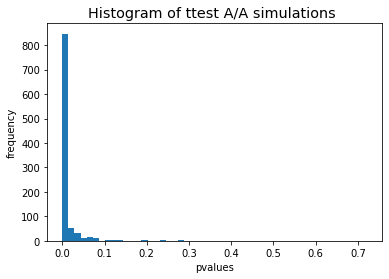

0.941

In [4]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Исходя из полученного графика и значения FPR, видим, что наша сплит-система работает неправильно. Посмотрим на наши данные подробнее. Сгруппируем по "experimentVariant" и проведем агрегацию по среднему значению "purchase", тем самым заодно посчитав конверсию.

In [5]:
df.groupby('experimentVariant', as_index = False).agg({'purchase': 'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


Видим, что уже присутствует видимое различие. Посмотрим на данные дальше и разобъем еще и по "версиям"

In [6]:
df_1 = df.groupby(['experimentVariant', 'version'], as_index = False)\
.agg({'purchase': 'mean'})\
.rename(columns = {'purchase': 'conversion'})

In [7]:
df_1

,experimentVariant,version,conversion
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Исходя из фрейма выше можно сделать предположение, что сплит-система не работает из-за проблем в "experimentVariant" = 0, "version" = v2.8.0, в котором значение конверсии сильно отличается от остальных значений.
Для проверки нашего предположения рассчитаем p-value в разбивке по версиям.

In [8]:
tt_v280 = stats.ttest_ind(df.query('version == "v2.8.0" and experimentVariant == 0').purchase, 
                df.query('version == "v2.8.0" and experimentVariant == 1').purchase)

In [9]:
tt_v280

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [10]:
tt_v290 = stats.ttest_ind(df.query('version == "v2.9.0" and experimentVariant == 0').purchase, 
                df.query('version == "v2.9.0" and experimentVariant == 1').purchase)

In [11]:
tt_v290

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [12]:
tt_v3740 = stats.ttest_ind(df.query('version == "v3.7.4.0" and experimentVariant == 0').purchase, 
                df.query('version == "v3.7.4.0" and experimentVariant == 1').purchase)

In [13]:
tt_v3740

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [14]:
tt_v3800 = stats.ttest_ind(df.query('version == "v3.8.0.0" and experimentVariant == 0').purchase, 
                df.query('version == "v3.8.0.0" and experimentVariant == 1').purchase)

In [15]:
tt_v3800

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Как видно из приведенных выше расчетов p-value только в случае версии 2.8.0 p-value < 0.05, а это значит, что мы отвергаем нулевую гипотезу о равенстве средних и говорим, что они отличаются, а в данном случае это говорит нам о том, что скорее всего именно здесь и кроется проблема нашей сплит-системы

Еще раз проведем А/А - тест, но уже с исключенной версией 2.8.0

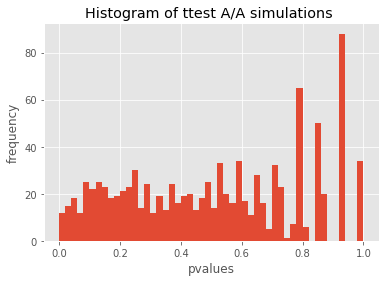

0.036

In [16]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В данном случае значение FPR < альфа и график говорят нам о том, что тепеь сплит-система работает правильно, а значит, поломка действительно кроется в версии 2.8.0.
Для достоверности проверим наш расчет также на других уровнях значимости.

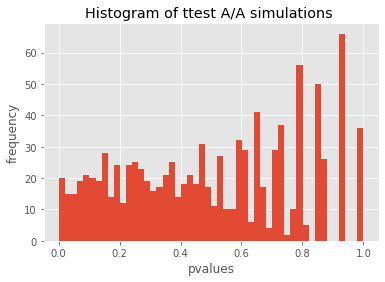

0.009

In [17]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.01) / simulations

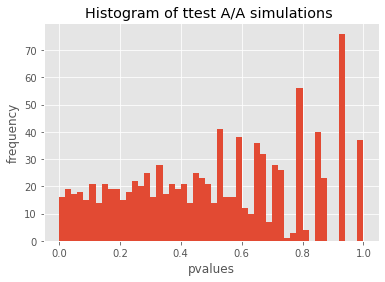

0.003

In [18]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 1 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.005) / simulations

Для других уровней значимости А/А - тест также работает, а значит тем более наше предположение, что поломка связана с версией 2.8.0 верна